In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.image import load_image
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.image_classification.models.darknet19 import DarkNet19FeatureExtractor
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.train import collate_fn
from torchlake.object_detection.controller.trainer_yolov2 import YOLOV2Trainer
from torchlake.common.controller.recorder import TrainRecorder

from torchlake.object_detection.models.yolov2 import YOLOV2, YOLOV2Loss, PriorBox
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.common.controller.weight_manager import WeightManager

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov2')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 5

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov2",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("voc.anchors.416.txt").as_posix(),
)

# data

In [7]:
BATCH_SIZE = 64

In [8]:
# paper used 544 for comparison, used 416 as standard
# IMAGE_SIZE = 416
IMAGE_SIZE = 544

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, erosion_rate=0.1),
        # A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [11]:
# train_dataset.env.close()

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 544, 544]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    # ...
    print(x.shape, len(y))
    break

torch.Size([64, 3, 544, 544]) 64


# model

If you don't have anchors yet, build one in debug section

In [15]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["3_1", "4_1"])

In [16]:
# backbone = DarkNet19FeatureExtractor("last_conv", "../../artifacts/darknet19/darknet19_448.pth", trainable=True)
# backbone.fix_target_layers(["3_1", "4_1"])

In [17]:
model = YOLOV2(
    backbone,
    CONTEXT,
    passthrough_feature_dim=backbone.feature_dims[-2],
    neck_feature_dim=backbone.feature_dims[-1],
).to(CONTEXT.device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV2                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─ResNet: 2-1                                 --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Module: 3-5                            221,952
│    │    └─Module: 3-6                            1,116,416
│    │    └─Module: 3-7                            6,822,400
│    │    └─Module: 3-8                            13,114,368
│    │    └─AdaptiveAvgPool2d: 3-9                 --
│    └─ImageNetNormalization: 2-2                  --
├─ModuleDict: 1-2                                  --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-10             8,256
│    │    └─StackedPatch2d: 3-11           

In [19]:
priorBox = PriorBox(CONTEXT)
anchors = priorBox.load_anchors()

# train

In [20]:
EPOCH = 100

In [21]:
trainer = YOLOV2Trainer(EPOCH, CONTEXT.device)

In [22]:
recorder = TrainRecorder(0, EPOCH, num_loss=5)
recorder.increment_data_size(len(train_dataset))

In [23]:
# underestimate the loss, since we drop last batch
recorder.data_size

16551

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = YOLOV2Loss(
    anchors,
    CONTEXT,
    prior_loss_threshold=BATCH_SIZE * 258, # one epoch
    return_all_loss=True,
)

In [25]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [26]:
scaler = torch.amp.GradScaler()

In [27]:
def validate_func(model):
    from torchlake.object_detection.models.yolov2.decode import Decoder
    from torchlake.object_detection.configs.schema import InferenceCfg
    from torchlake.object_detection.controller.predictor import Predictor
    from torchlake.object_detection.controller.evaluator import Evaluator
    
    decoder = Decoder(anchors.to("cpu"), CONTEXT)
    inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)
    
    predictor = Predictor(CONTEXT)
    predictor.set_postprocess_cfg(decoder, inferCfg)
    
    test_transform = A.Compose(
        [
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(0, 1),
            ToTensorV2(),
        ]
    )
    
    test_dataset = VOCDetectionFromCSV(
        data_path,
        data_path.joinpath("voc_test.csv"),
        transform=test_transform,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        # num_workers=get_num_workers(),
        collate_fn=collate_fn,
    )
    
    evaluator = Evaluator(CONTEXT)
    
    result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES, verbose=False)
    
    print("validation mAP:", result_table['all'])

In [28]:
manager = WeightManager(artifact_path.joinpath("yolov2.{backbone_name}.{image_size}.{epoch}.pth").as_posix())
optimizer_manager = WeightManager(artifact_path.joinpath("adam.{lr:.1e}.{decay:.1e}.{epoch}.pth").as_posix())

In [29]:
def checkpoint_func(model: YOLOV2, optimizer: torch.optim.Optimizer):
    filename = manager.get_filename(
        backbone_name=model.foot.network_name,
        image_size=IMAGE_SIZE,
        epoch=recorder.current_epoch,
    )
    manager.save_weight(model.state_dict(), filename)
    
    param_group = optimizer.param_groups[0]
    filename = optimizer_manager.get_filename(
        lr=param_group['lr'],
        decay=param_group['weight_decay'],
        epoch=recorder.current_epoch,
    )
    optimizer_manager.save_weight(optimizer.state_dict(), filename)

In [30]:
import random

def at_epoch_end_hook():
    random_size = random.randint(10, 19) * 32
    transform.transforms[2].height = random_size
    transform.transforms[2].width = random_size
    print(f"resize to {random_size}")

In [31]:
trainer.reset_seen()

In [32]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    scaler=scaler,
    validate_func=validate_func,
    checkpoint_func=checkpoint_func,
    # at_epoch_end_hook=at_epoch_end_hook,
)

Enable AMP: True
Training...


100%|██████████| 258/258 [16:39<00:00,  3.88s/it]


------------------------------------
Epoch 1
------------------------------------
total: 5.0594e+01 (0.00%)
subloss 1: 1.8823e+00 (0.00%)
subloss 2: 4.4120e+01 (0.00%)
subloss 3: 3.7708e-01 (0.00%)
subloss 4: 9.2746e-01 (0.00%)


100%|██████████| 258/258 [03:42<00:00,  1.16it/s]


------------------------------------
Epoch 2
------------------------------------
total: 8.0308e+00 (-84.00%)
subloss 1: 1.5738e+00 (-16.00%)
subloss 2: 1.9553e+00 (-96.00%)
subloss 3: 7.2546e-01 (92.00%)
subloss 4: 8.7439e-01 (-6.00%)


100%|██████████| 258/258 [03:41<00:00,  1.17it/s]


------------------------------------
Epoch 3
------------------------------------
total: 6.5894e+00 (-18.00%)
subloss 1: 1.3408e+00 (-15.00%)
subloss 2: 1.0170e+00 (-48.00%)
subloss 3: 7.5693e-01 (4.00%)
subloss 4: 4.4694e-01 (-49.00%)


100%|██████████| 258/258 [03:41<00:00,  1.17it/s]


------------------------------------
Epoch 4
------------------------------------
total: 5.8422e+00 (-11.00%)
subloss 1: 1.1080e+00 (-17.00%)
subloss 2: 1.0335e+00 (2.00%)
subloss 3: 6.5441e-01 (-14.00%)
subloss 4: 4.2867e-01 (-4.00%)


100%|██████████| 258/258 [05:25<00:00,  1.26s/it]


------------------------------------
Epoch 5
------------------------------------
total: 4.8931e+00 (-16.00%)
subloss 1: 8.4186e-01 (-24.00%)
subloss 2: 9.5276e-01 (-8.00%)
subloss 3: 5.4736e-01 (-16.00%)
subloss 4: 3.6165e-01 (-16.00%)


100%|██████████| 258/258 [05:50<00:00,  1.36s/it]


------------------------------------
Epoch 6
------------------------------------
total: 4.2136e+00 (-14.00%)
subloss 1: 6.4729e-01 (-23.00%)
subloss 2: 8.8215e-01 (-7.00%)
subloss 3: 4.7604e-01 (-13.00%)
subloss 4: 3.0392e-01 (-16.00%)


100%|██████████| 258/258 [04:15<00:00,  1.01it/s]


------------------------------------
Epoch 7
------------------------------------
total: 3.8017e+00 (-10.00%)
subloss 1: 5.3822e-01 (-17.00%)
subloss 2: 8.1875e-01 (-7.00%)
subloss 3: 4.2913e-01 (-10.00%)
subloss 4: 2.9912e-01 (-2.00%)


100%|██████████| 258/258 [03:42<00:00,  1.16it/s]


------------------------------------
Epoch 8
------------------------------------
total: 3.5123e+00 (-8.00%)
subloss 1: 4.6769e-01 (-13.00%)
subloss 2: 7.5556e-01 (-8.00%)
subloss 3: 3.9342e-01 (-8.00%)
subloss 4: 3.2194e-01 (8.00%)


100%|██████████| 258/258 [03:41<00:00,  1.17it/s]


------------------------------------
Epoch 9
------------------------------------
total: 3.2636e+00 (-7.00%)
subloss 1: 4.2373e-01 (-9.00%)
subloss 2: 7.0497e-01 (-7.00%)
subloss 3: 3.6096e-01 (-8.00%)
subloss 4: 3.3009e-01 (3.00%)


100%|██████████| 258/258 [03:41<00:00,  1.17it/s]


------------------------------------
Epoch 10
------------------------------------
total: 2.9834e+00 (-9.00%)
subloss 1: 3.7504e-01 (-11.00%)
subloss 2: 6.5294e-01 (-7.00%)
subloss 3: 3.3621e-01 (-7.00%)
subloss 4: 2.7434e-01 (-17.00%)
Validating...


100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


validation mAP: AP@0.5    0.549069
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.10.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-04.1.0e-05.10.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:36<00:00,  1.19it/s]


------------------------------------
Epoch 11
------------------------------------
total: 3.2092e+00 (8.00%)
subloss 1: 4.6958e-01 (25.00%)
subloss 2: 6.1502e-01 (-6.00%)
subloss 3: 3.5743e-01 (6.00%)
subloss 4: 3.3739e-01 (23.00%)


100%|██████████| 258/258 [04:31<00:00,  1.05s/it]


------------------------------------
Epoch 12
------------------------------------
total: 2.9216e+00 (-9.00%)
subloss 1: 4.0990e-01 (-13.00%)
subloss 2: 5.8233e-01 (-5.00%)
subloss 3: 3.2994e-01 (-8.00%)
subloss 4: 2.7965e-01 (-17.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 13
------------------------------------
total: 2.7160e+00 (-7.00%)
subloss 1: 3.7864e-01 (-8.00%)
subloss 2: 5.6155e-01 (-4.00%)
subloss 3: 3.1047e-01 (-6.00%)
subloss 4: 2.2348e-01 (-20.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 14
------------------------------------
total: 2.6444e+00 (-3.00%)
subloss 1: 3.5743e-01 (-6.00%)
subloss 2: 5.4863e-01 (-2.00%)
subloss 3: 2.9535e-01 (-5.00%)
subloss 4: 2.6161e-01 (17.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 15
------------------------------------
total: 2.5470e+00 (-4.00%)
subloss 1: 3.4484e-01 (-4.00%)
subloss 2: 5.4237e-01 (-1.00%)
subloss 3: 2.8463e-01 (-4.00%)
subloss 4: 2.3667e-01 (-10.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 16
------------------------------------
total: 2.5144e+00 (-1.00%)
subloss 1: 3.3085e-01 (-4.00%)
subloss 2: 5.1266e-01 (-5.00%)
subloss 3: 2.7295e-01 (-4.00%)
subloss 4: 3.0617e-01 (29.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 17
------------------------------------
total: 2.3756e+00 (-6.00%)
subloss 1: 2.9489e-01 (-11.00%)
subloss 2: 5.0825e-01 (-1.00%)
subloss 3: 2.6376e-01 (-3.00%)
subloss 4: 2.5364e-01 (-17.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 18
------------------------------------
total: 2.3021e+00 (-3.00%)
subloss 1: 2.8546e-01 (-3.00%)
subloss 2: 4.9823e-01 (-2.00%)
subloss 3: 2.5164e-01 (-5.00%)
subloss 4: 2.6020e-01 (3.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 19
------------------------------------
total: 2.2882e+00 (-1.00%)
subloss 1: 2.7841e-01 (-2.00%)
subloss 2: 4.8277e-01 (-3.00%)
subloss 3: 2.4841e-01 (-1.00%)
subloss 4: 2.8496e-01 (10.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 20
------------------------------------
total: 2.1559e+00 (-6.00%)
subloss 1: 2.6946e-01 (-3.00%)
subloss 2: 4.7763e-01 (-1.00%)
subloss 3: 2.3631e-01 (-5.00%)
subloss 4: 2.2731e-01 (-20.00%)
Validating...


100%|██████████| 78/78 [01:44<00:00,  1.34s/it]


validation mAP: AP@0.5    0.592065
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.20.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-04.1.0e-05.20.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:16<00:00,  1.22s/it]


------------------------------------
Epoch 21
------------------------------------
total: 2.1337e+00 (-1.00%)
subloss 1: 2.6291e-01 (-2.00%)
subloss 2: 4.6673e-01 (-2.00%)
subloss 3: 2.3313e-01 (-1.00%)
subloss 4: 2.3843e-01 (5.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 22
------------------------------------
total: 2.0428e+00 (-4.00%)
subloss 1: 2.4550e-01 (-7.00%)
subloss 2: 4.5359e-01 (-3.00%)
subloss 3: 2.2290e-01 (-4.00%)
subloss 4: 2.2924e-01 (-4.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 23
------------------------------------
total: 1.9796e+00 (-3.00%)
subloss 1: 2.4295e-01 (-1.00%)
subloss 2: 4.4444e-01 (-2.00%)
subloss 3: 2.1921e-01 (-2.00%)
subloss 4: 1.9615e-01 (-14.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 24
------------------------------------
total: 1.9567e+00 (-1.00%)
subloss 1: 2.3508e-01 (-3.00%)
subloss 2: 4.3815e-01 (-1.00%)
subloss 3: 2.1188e-01 (-3.00%)
subloss 4: 2.2410e-01 (14.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 25
------------------------------------
total: 1.8501e+00 (-5.00%)
subloss 1: 2.2220e-01 (-5.00%)
subloss 2: 4.2891e-01 (-2.00%)
subloss 3: 2.0775e-01 (-2.00%)
subloss 4: 1.6029e-01 (-28.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 26
------------------------------------
total: 1.8056e+00 (-2.00%)
subloss 1: 2.0812e-01 (-6.00%)
subloss 2: 4.1281e-01 (-4.00%)
subloss 3: 1.9988e-01 (-4.00%)
subloss 4: 1.8526e-01 (16.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 27
------------------------------------
total: 1.8033e+00 (0.00%)
subloss 1: 2.0654e-01 (-1.00%)
subloss 2: 4.0636e-01 (-2.00%)
subloss 3: 1.9557e-01 (-2.00%)
subloss 4: 2.1253e-01 (15.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 28
------------------------------------
total: 1.7513e+00 (-3.00%)
subloss 1: 1.9976e-01 (-3.00%)
subloss 2: 4.0167e-01 (-1.00%)
subloss 3: 1.9356e-01 (-1.00%)
subloss 4: 1.8209e-01 (-14.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 29
------------------------------------
total: 1.7648e+00 (1.00%)
subloss 1: 1.9736e-01 (-1.00%)
subloss 2: 3.9508e-01 (-2.00%)
subloss 3: 1.8961e-01 (-2.00%)
subloss 4: 2.2432e-01 (23.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 30
------------------------------------
total: 1.7103e+00 (-3.00%)
subloss 1: 1.9330e-01 (-2.00%)
subloss 2: 3.8800e-01 (-2.00%)
subloss 3: 1.8650e-01 (-2.00%)
subloss 4: 1.9651e-01 (-12.00%)
Validating...


100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


validation mAP: AP@0.5    0.619825
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.30.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-04.1.0e-05.30.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 31
------------------------------------
total: 1.6647e+00 (-3.00%)
subloss 1: 1.8521e-01 (-4.00%)
subloss 2: 3.8081e-01 (-2.00%)
subloss 3: 1.8201e-01 (-2.00%)
subloss 4: 1.8858e-01 (-4.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 32
------------------------------------
total: 1.3036e+00 (-22.00%)
subloss 1: 1.1145e-01 (-40.00%)
subloss 2: 2.9594e-01 (-22.00%)
subloss 3: 1.4705e-01 (-19.00%)
subloss 4: 1.6093e-01 (-15.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 33
------------------------------------
total: 1.1693e+00 (-10.00%)
subloss 1: 9.7613e-02 (-12.00%)
subloss 2: 2.6858e-01 (-9.00%)
subloss 3: 1.3580e-01 (-8.00%)
subloss 4: 1.2412e-01 (-23.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 34
------------------------------------
total: 1.1348e+00 (-3.00%)
subloss 1: 8.8072e-02 (-10.00%)
subloss 2: 2.5101e-01 (-7.00%)
subloss 3: 1.3189e-01 (-3.00%)
subloss 4: 1.3627e-01 (10.00%)


100%|██████████| 258/258 [05:16<00:00,  1.22s/it]


------------------------------------
Epoch 35
------------------------------------
total: 1.0879e+00 (-4.00%)
subloss 1: 8.2757e-02 (-6.00%)
subloss 2: 2.4868e-01 (-1.00%)
subloss 3: 1.2725e-01 (-4.00%)
subloss 4: 1.2018e-01 (-12.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 36
------------------------------------
total: 1.1112e+00 (2.00%)
subloss 1: 8.3807e-02 (1.00%)
subloss 2: 2.3777e-01 (-4.00%)
subloss 3: 1.2601e-01 (-1.00%)
subloss 4: 1.5955e-01 (33.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 37
------------------------------------
total: 1.0717e+00 (-4.00%)
subloss 1: 7.8500e-02 (-6.00%)
subloss 2: 2.3194e-01 (-2.00%)
subloss 3: 1.2294e-01 (-2.00%)
subloss 4: 1.4650e-01 (-8.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 38
------------------------------------
total: 1.0452e+00 (-2.00%)
subloss 1: 7.6751e-02 (-2.00%)
subloss 2: 2.3354e-01 (1.00%)
subloss 3: 1.2014e-01 (-2.00%)
subloss 4: 1.3420e-01 (-8.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 39
------------------------------------
total: 1.0203e+00 (-2.00%)
subloss 1: 7.3812e-02 (-4.00%)
subloss 2: 2.2421e-01 (-4.00%)
subloss 3: 1.1795e-01 (-2.00%)
subloss 4: 1.3254e-01 (-1.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 40
------------------------------------
total: 1.0042e+00 (-2.00%)
subloss 1: 7.3264e-02 (-1.00%)
subloss 2: 2.1998e-01 (-2.00%)
subloss 3: 1.1821e-01 (0.00%)
subloss 4: 1.1992e-01 (-10.00%)
Validating...


100%|██████████| 78/78 [01:45<00:00,  1.36s/it]


validation mAP: AP@0.5    0.676954
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.40.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-06.1.0e-05.40.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 41
------------------------------------
total: 1.0205e+00 (2.00%)
subloss 1: 7.2721e-02 (-1.00%)
subloss 2: 2.1934e-01 (0.00%)
subloss 3: 1.1631e-01 (-2.00%)
subloss 4: 1.4685e-01 (22.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 42
------------------------------------
total: 9.6982e-01 (-5.00%)
subloss 1: 7.3508e-02 (1.00%)
subloss 2: 2.1844e-01 (0.00%)
subloss 3: 1.1553e-01 (-1.00%)
subloss 4: 1.0023e-01 (-32.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 43
------------------------------------
total: 9.8706e-01 (2.00%)
subloss 1: 7.2268e-02 (-2.00%)
subloss 2: 2.1120e-01 (-3.00%)
subloss 3: 1.1516e-01 (0.00%)
subloss 4: 1.2780e-01 (28.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 44
------------------------------------
total: 1.0128e+00 (3.00%)
subloss 1: 6.9552e-02 (-4.00%)
subloss 2: 2.1758e-01 (3.00%)
subloss 3: 1.1625e-01 (1.00%)
subloss 4: 1.4445e-01 (13.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 45
------------------------------------
total: 9.8103e-01 (-3.00%)
subloss 1: 7.0239e-02 (1.00%)
subloss 2: 2.1614e-01 (-1.00%)
subloss 3: 1.1622e-01 (0.00%)
subloss 4: 1.1354e-01 (-21.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 46
------------------------------------
total: 9.7946e-01 (0.00%)
subloss 1: 7.0266e-02 (0.00%)
subloss 2: 2.1626e-01 (0.00%)
subloss 3: 1.1596e-01 (0.00%)
subloss 4: 1.1312e-01 (0.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 47
------------------------------------
total: 9.8340e-01 (0.00%)
subloss 1: 7.1816e-02 (2.00%)
subloss 2: 2.1518e-01 (0.00%)
subloss 3: 1.1283e-01 (-3.00%)
subloss 4: 1.3225e-01 (17.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 48
------------------------------------
total: 9.9370e-01 (1.00%)
subloss 1: 7.0576e-02 (-2.00%)
subloss 2: 2.1695e-01 (1.00%)
subloss 3: 1.1544e-01 (2.00%)
subloss 4: 1.2897e-01 (-2.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 49
------------------------------------
total: 9.9887e-01 (1.00%)
subloss 1: 7.2203e-02 (2.00%)
subloss 2: 2.1527e-01 (-1.00%)
subloss 3: 1.1619e-01 (1.00%)
subloss 4: 1.3045e-01 (1.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 50
------------------------------------
total: 1.0135e+00 (1.00%)
subloss 1: 7.1427e-02 (-1.00%)
subloss 2: 2.1853e-01 (2.00%)
subloss 3: 1.1555e-01 (-1.00%)
subloss 4: 1.4584e-01 (12.00%)
Validating...


100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


validation mAP: AP@0.5    0.676723
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.50.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-08.1.0e-05.50.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 51
------------------------------------
total: 9.8942e-01 (-2.00%)
subloss 1: 7.1207e-02 (0.00%)
subloss 2: 2.1840e-01 (0.00%)
subloss 3: 1.1521e-01 (0.00%)
subloss 4: 1.2377e-01 (-15.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 52
------------------------------------
total: 9.5615e-01 (-3.00%)
subloss 1: 7.0862e-02 (0.00%)
subloss 2: 2.1357e-01 (-2.00%)
subloss 3: 1.1436e-01 (-1.00%)
subloss 4: 9.9920e-02 (-19.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 53
------------------------------------
total: 9.8984e-01 (4.00%)
subloss 1: 7.0746e-02 (0.00%)
subloss 2: 2.1579e-01 (1.00%)
subloss 3: 1.1581e-01 (1.00%)
subloss 4: 1.2427e-01 (24.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 54
------------------------------------
total: 1.0122e+00 (2.00%)
subloss 1: 7.1123e-02 (1.00%)
subloss 2: 2.1643e-01 (0.00%)
subloss 3: 1.1677e-01 (1.00%)
subloss 4: 1.4078e-01 (13.00%)


100%|██████████| 258/258 [05:12<00:00,  1.21s/it]


------------------------------------
Epoch 55
------------------------------------
total: 1.0120e+00 (0.00%)
subloss 1: 7.0557e-02 (-1.00%)
subloss 2: 2.1680e-01 (0.00%)
subloss 3: 1.1519e-01 (-1.00%)
subloss 4: 1.4871e-01 (6.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 56
------------------------------------
total: 1.0589e+00 (5.00%)
subloss 1: 6.9075e-02 (-2.00%)
subloss 2: 2.1700e-01 (0.00%)
subloss 3: 1.1549e-01 (0.00%)
subloss 4: 1.9537e-01 (31.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 57
------------------------------------
total: 9.8726e-01 (-7.00%)
subloss 1: 7.1923e-02 (4.00%)
subloss 2: 2.1758e-01 (0.00%)
subloss 3: 1.1437e-01 (-1.00%)
subloss 4: 1.2593e-01 (-36.00%)


100%|██████████| 258/258 [05:12<00:00,  1.21s/it]


------------------------------------
Epoch 58
------------------------------------
total: 1.0580e+00 (7.00%)
subloss 1: 7.0474e-02 (-2.00%)
subloss 2: 2.1646e-01 (-1.00%)
subloss 3: 1.1479e-01 (0.00%)
subloss 4: 1.9712e-01 (57.00%)


100%|██████████| 258/258 [05:12<00:00,  1.21s/it]


------------------------------------
Epoch 59
------------------------------------
total: 1.0441e+00 (-1.00%)
subloss 1: 7.1182e-02 (1.00%)
subloss 2: 2.1509e-01 (-1.00%)
subloss 3: 1.1532e-01 (0.00%)
subloss 4: 1.8120e-01 (-8.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 60
------------------------------------
total: 1.0635e+00 (2.00%)
subloss 1: 6.9730e-02 (-2.00%)
subloss 2: 2.1675e-01 (1.00%)
subloss 3: 1.1545e-01 (0.00%)
subloss 4: 1.9976e-01 (10.00%)
Validating...


100%|██████████| 78/78 [01:43<00:00,  1.32s/it]


validation mAP: AP@0.5    0.676952
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.60.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-08.1.0e-05.60.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 61
------------------------------------
total: 1.0753e+00 (1.00%)
subloss 1: 7.2964e-02 (5.00%)
subloss 2: 2.1684e-01 (0.00%)
subloss 3: 1.1542e-01 (0.00%)
subloss 4: 2.0838e-01 (4.00%)


100%|██████████| 258/258 [05:11<00:00,  1.21s/it]


------------------------------------
Epoch 62
------------------------------------
total: 9.7586e-01 (-9.00%)
subloss 1: 7.0703e-02 (-3.00%)
subloss 2: 2.1673e-01 (0.00%)
subloss 3: 1.1424e-01 (-1.00%)
subloss 4: 1.1725e-01 (-44.00%)


100%|██████████| 258/258 [05:12<00:00,  1.21s/it]


------------------------------------
Epoch 63
------------------------------------
total: 9.5348e-01 (-2.00%)
subloss 1: 6.9900e-02 (-1.00%)
subloss 2: 2.1699e-01 (0.00%)
subloss 3: 1.1384e-01 (0.00%)
subloss 4: 9.7394e-02 (-17.00%)


100%|██████████| 258/258 [05:10<00:00,  1.20s/it]


------------------------------------
Epoch 64
------------------------------------
total: 9.5766e-01 (0.00%)
subloss 1: 6.9582e-02 (0.00%)
subloss 2: 2.1512e-01 (-1.00%)
subloss 3: 1.1364e-01 (0.00%)
subloss 4: 1.0477e-01 (8.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 65
------------------------------------
total: 9.9937e-01 (4.00%)
subloss 1: 7.2925e-02 (5.00%)
subloss 2: 2.1508e-01 (0.00%)
subloss 3: 1.1420e-01 (0.00%)
subloss 4: 1.4036e-01 (34.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 66
------------------------------------
total: 9.8142e-01 (-2.00%)
subloss 1: 6.8698e-02 (-6.00%)
subloss 2: 2.1596e-01 (0.00%)
subloss 3: 1.1763e-01 (3.00%)
subloss 4: 1.0860e-01 (-23.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 67
------------------------------------
total: 9.6738e-01 (-1.00%)
subloss 1: 7.0570e-02 (3.00%)
subloss 2: 2.1575e-01 (0.00%)
subloss 3: 1.1591e-01 (-1.00%)
subloss 4: 1.0148e-01 (-7.00%)


100%|██████████| 258/258 [05:10<00:00,  1.21s/it]


------------------------------------
Epoch 68
------------------------------------
total: 1.0019e+00 (4.00%)
subloss 1: 7.2069e-02 (2.00%)
subloss 2: 2.1319e-01 (-1.00%)
subloss 3: 1.1548e-01 (0.00%)
subloss 4: 1.3925e-01 (37.00%)


100%|██████████| 258/258 [05:10<00:00,  1.20s/it]


------------------------------------
Epoch 69
------------------------------------
total: 9.9002e-01 (-1.00%)
subloss 1: 6.9657e-02 (-3.00%)
subloss 2: 2.1799e-01 (2.00%)
subloss 3: 1.1613e-01 (1.00%)
subloss 4: 1.2173e-01 (-13.00%)


100%|██████████| 258/258 [05:11<00:00,  1.21s/it]


------------------------------------
Epoch 70
------------------------------------
total: 1.0480e+00 (6.00%)
subloss 1: 7.0626e-02 (1.00%)
subloss 2: 2.1327e-01 (-2.00%)
subloss 3: 1.1406e-01 (-2.00%)
subloss 4: 1.9380e-01 (59.00%)
Validating...


100%|██████████| 78/78 [01:43<00:00,  1.32s/it]


validation mAP: AP@0.5    0.677062
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.70.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-08.1.0e-05.70.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 71
------------------------------------
total: 9.8598e-01 (-6.00%)
subloss 1: 7.1181e-02 (1.00%)
subloss 2: 2.1576e-01 (1.00%)
subloss 3: 1.1483e-01 (1.00%)
subloss 4: 1.2489e-01 (-36.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 72
------------------------------------
total: 1.0122e+00 (3.00%)
subloss 1: 7.0493e-02 (-1.00%)
subloss 2: 2.1579e-01 (0.00%)
subloss 3: 1.1694e-01 (2.00%)
subloss 4: 1.4124e-01 (13.00%)


100%|██████████| 258/258 [05:10<00:00,  1.20s/it]


------------------------------------
Epoch 73
------------------------------------
total: 9.6648e-01 (-5.00%)
subloss 1: 7.1262e-02 (1.00%)
subloss 2: 2.1283e-01 (-1.00%)
subloss 3: 1.1577e-01 (-1.00%)
subloss 4: 1.0356e-01 (-27.00%)


100%|██████████| 258/258 [05:14<00:00,  1.22s/it]


------------------------------------
Epoch 74
------------------------------------
total: 1.0043e+00 (4.00%)
subloss 1: 7.2776e-02 (2.00%)
subloss 2: 2.1685e-01 (2.00%)
subloss 3: 1.1584e-01 (0.00%)
subloss 4: 1.3550e-01 (31.00%)


100%|██████████| 258/258 [05:10<00:00,  1.20s/it]


------------------------------------
Epoch 75
------------------------------------
total: 1.0084e+00 (0.00%)
subloss 1: 7.1961e-02 (-1.00%)
subloss 2: 2.1483e-01 (-1.00%)
subloss 3: 1.1499e-01 (-1.00%)
subloss 4: 1.4667e-01 (8.00%)


100%|██████████| 258/258 [05:10<00:00,  1.21s/it]


------------------------------------
Epoch 76
------------------------------------
total: 9.6185e-01 (-5.00%)
subloss 1: 6.9949e-02 (-3.00%)
subloss 2: 2.1643e-01 (1.00%)
subloss 3: 1.1430e-01 (-1.00%)
subloss 4: 1.0396e-01 (-29.00%)


100%|██████████| 258/258 [05:12<00:00,  1.21s/it]


------------------------------------
Epoch 77
------------------------------------
total: 1.0058e+00 (5.00%)
subloss 1: 6.9606e-02 (0.00%)
subloss 2: 2.1672e-01 (0.00%)
subloss 3: 1.1509e-01 (1.00%)
subloss 4: 1.4403e-01 (39.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 78
------------------------------------
total: 1.0464e+00 (4.00%)
subloss 1: 6.7713e-02 (-3.00%)
subloss 2: 2.1694e-01 (0.00%)
subloss 3: 1.1379e-01 (-1.00%)
subloss 4: 1.9281e-01 (34.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 79
------------------------------------
total: 9.8838e-01 (-6.00%)
subloss 1: 7.0922e-02 (5.00%)
subloss 2: 2.1671e-01 (0.00%)
subloss 3: 1.1513e-01 (1.00%)
subloss 4: 1.2509e-01 (-35.00%)


100%|██████████| 258/258 [05:13<00:00,  1.21s/it]


------------------------------------
Epoch 80
------------------------------------
total: 1.0059e+00 (2.00%)
subloss 1: 7.0373e-02 (-1.00%)
subloss 2: 2.1823e-01 (1.00%)
subloss 3: 1.1678e-01 (1.00%)
subloss 4: 1.3343e-01 (7.00%)
Validating...


100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


validation mAP: AP@0.5    0.677022
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.80.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-08.1.0e-05.80.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:11<00:00,  1.21s/it]


------------------------------------
Epoch 81
------------------------------------
total: 1.0679e+00 (6.00%)
subloss 1: 7.1045e-02 (1.00%)
subloss 2: 2.2035e-01 (1.00%)
subloss 3: 1.1491e-01 (-2.00%)
subloss 4: 2.0198e-01 (51.00%)


100%|██████████| 258/258 [05:13<00:00,  1.22s/it]


------------------------------------
Epoch 82
------------------------------------
total: 9.6729e-01 (-9.00%)
subloss 1: 6.9537e-02 (-2.00%)
subloss 2: 2.1745e-01 (-1.00%)
subloss 3: 1.1492e-01 (0.00%)
subloss 4: 1.0570e-01 (-48.00%)


100%|██████████| 258/258 [05:03<00:00,  1.18s/it]


------------------------------------
Epoch 83
------------------------------------
total: 9.9570e-01 (3.00%)
subloss 1: 7.3637e-02 (6.00%)
subloss 2: 2.1747e-01 (0.00%)
subloss 3: 1.1484e-01 (0.00%)
subloss 4: 1.3041e-01 (23.00%)


100%|██████████| 258/258 [03:41<00:00,  1.17it/s]


------------------------------------
Epoch 84
------------------------------------
total: 1.0242e+00 (3.00%)
subloss 1: 6.9960e-02 (-5.00%)
subloss 2: 2.1808e-01 (0.00%)
subloss 3: 1.1488e-01 (0.00%)
subloss 4: 1.6173e-01 (24.00%)


100%|██████████| 258/258 [05:18<00:00,  1.23s/it]


------------------------------------
Epoch 85
------------------------------------
total: 1.0055e+00 (-2.00%)
subloss 1: 7.2380e-02 (3.00%)
subloss 2: 2.1425e-01 (-2.00%)
subloss 3: 1.1417e-01 (-1.00%)
subloss 4: 1.4799e-01 (-9.00%)


100%|██████████| 258/258 [05:25<00:00,  1.26s/it]


------------------------------------
Epoch 86
------------------------------------
total: 9.8237e-01 (-2.00%)
subloss 1: 6.9344e-02 (-4.00%)
subloss 2: 2.1609e-01 (1.00%)
subloss 3: 1.1447e-01 (0.00%)
subloss 4: 1.2460e-01 (-16.00%)


100%|██████████| 258/258 [05:25<00:00,  1.26s/it]


------------------------------------
Epoch 87
------------------------------------
total: 1.0603e+00 (8.00%)
subloss 1: 7.1171e-02 (3.00%)
subloss 2: 2.1753e-01 (1.00%)
subloss 3: 1.1623e-01 (2.00%)
subloss 4: 1.9042e-01 (53.00%)


100%|██████████| 258/258 [05:22<00:00,  1.25s/it]


------------------------------------
Epoch 88
------------------------------------
total: 1.0713e+00 (1.00%)
subloss 1: 7.1531e-02 (1.00%)
subloss 2: 2.1489e-01 (-1.00%)
subloss 3: 1.1539e-01 (-1.00%)
subloss 4: 2.0797e-01 (9.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 89
------------------------------------
total: 9.9112e-01 (-7.00%)
subloss 1: 6.9632e-02 (-3.00%)
subloss 2: 2.1487e-01 (0.00%)
subloss 3: 1.1503e-01 (0.00%)
subloss 4: 1.3144e-01 (-37.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 90
------------------------------------
total: 9.8080e-01 (-1.00%)
subloss 1: 7.0212e-02 (1.00%)
subloss 2: 2.1364e-01 (-1.00%)
subloss 3: 1.1457e-01 (0.00%)
subloss 4: 1.2408e-01 (-6.00%)
Validating...


100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


validation mAP: AP@0.5    0.677113
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.90.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-08.1.0e-05.90.pth, model size is 352.58MiB


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 91
------------------------------------
total: 9.5135e-01 (-3.00%)
subloss 1: 7.0423e-02 (0.00%)
subloss 2: 2.1444e-01 (0.00%)
subloss 3: 1.1534e-01 (1.00%)
subloss 4: 8.9773e-02 (-28.00%)


100%|██████████| 258/258 [05:15<00:00,  1.22s/it]


------------------------------------
Epoch 92
------------------------------------
total: 1.0397e+00 (9.00%)
subloss 1: 6.7680e-02 (-4.00%)
subloss 2: 2.1707e-01 (1.00%)
subloss 3: 1.1483e-01 (0.00%)
subloss 4: 1.8079e-01 (101.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 93
------------------------------------
total: 9.6275e-01 (-7.00%)
subloss 1: 7.1332e-02 (5.00%)
subloss 2: 2.1638e-01 (0.00%)
subloss 3: 1.1431e-01 (0.00%)
subloss 4: 1.0347e-01 (-43.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 94
------------------------------------
total: 1.0302e+00 (7.00%)
subloss 1: 7.2148e-02 (1.00%)
subloss 2: 2.1663e-01 (0.00%)
subloss 3: 1.1575e-01 (1.00%)
subloss 4: 1.6274e-01 (57.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 95
------------------------------------
total: 1.0177e+00 (-1.00%)
subloss 1: 7.0423e-02 (-2.00%)
subloss 2: 2.1866e-01 (1.00%)
subloss 3: 1.1639e-01 (1.00%)
subloss 4: 1.4668e-01 (-10.00%)


100%|██████████| 258/258 [05:17<00:00,  1.23s/it]


------------------------------------
Epoch 96
------------------------------------
total: 9.9345e-01 (-2.00%)
subloss 1: 7.1838e-02 (2.00%)
subloss 2: 2.1810e-01 (0.00%)
subloss 3: 1.1541e-01 (-1.00%)
subloss 4: 1.2644e-01 (-14.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 97
------------------------------------
total: 9.8346e-01 (-1.00%)
subloss 1: 7.2930e-02 (2.00%)
subloss 2: 2.1556e-01 (-1.00%)
subloss 3: 1.1565e-01 (0.00%)
subloss 4: 1.1671e-01 (-8.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 98
------------------------------------
total: 1.0206e+00 (4.00%)
subloss 1: 7.0219e-02 (-4.00%)
subloss 2: 2.1499e-01 (0.00%)
subloss 3: 1.1494e-01 (-1.00%)
subloss 4: 1.6068e-01 (38.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 99
------------------------------------
total: 9.8805e-01 (-3.00%)
subloss 1: 6.7758e-02 (-4.00%)
subloss 2: 2.1856e-01 (2.00%)
subloss 3: 1.1399e-01 (-1.00%)
subloss 4: 1.3178e-01 (-18.00%)


100%|██████████| 258/258 [05:16<00:00,  1.23s/it]


------------------------------------
Epoch 100
------------------------------------
total: 1.0184e+00 (3.00%)
subloss 1: 6.8938e-02 (2.00%)
subloss 2: 2.1681e-01 (-1.00%)
subloss 3: 1.1381e-01 (0.00%)
subloss 4: 1.6364e-01 (24.00%)
Validating...


100%|██████████| 78/78 [01:44<00:00,  1.34s/it]


validation mAP: AP@0.5    0.677145
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.544.100.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0e-08.1.0e-05.100.pth, model size is 352.58MiB


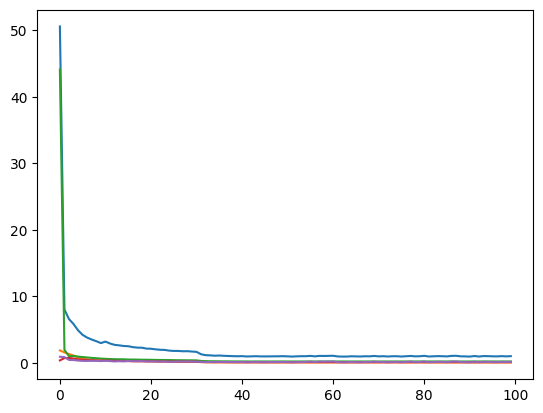

In [33]:
plt.plot(torch.Tensor(recorder.training_losses).T)

# load

In [21]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{image_size}.{epoch}.pth").as_posix())

In [22]:
model_path = manager.get_filename(
    detector_name=CONTEXT.detector_name,
    backbone_name=backbone.network_name,
    image_size=IMAGE_SIZE,
    # epoch=recorder.current_epoch,
    epoch=100,
)

In [23]:
model_path

WindowsPath('../../artifacts/yolov2/yolov2.resnet34.544.100.pth')

In [24]:
manager.load_weight(model_path, model)

# Inference

In [50]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [51]:
decoder = Decoder(anchors.to("cpu"), CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [52]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [53]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="yolo",
    #     # min_area=1024,
    #     # min_visibility=0.3,
    # ),
)

In [54]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [55]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [56]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [57]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [68]:
model.eval()
with torch.no_grad():
    for img, _ in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B x (?, 25)
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/77 [00:01<?, ?it/s]


In [47]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     decoded = decoder.decode(output.cpu(), (IMAGE_SIZE, IMAGE_SIZE))
#     boxes = decoded[4]
#     # boxes = output[0].unflatten(0, (5, 25)).permute(0, 2, 3, 1).reshape(-1, 25)
#     print(boxes[boxes[:, 4] > 0.1])

In [48]:
# boxes[169*1:169*2, 4]

In [69]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

car: 0.93
person: 0.35
person: 0.55
person: 0.74
tvmonitor: 0.85
chair: 0.89
chair: 0.52
tvmonitor: 0.48
tvmonitor: 0.51
cow: 0.66
cow: 0.58
cow: 0.68
cow: 0.73
diningtable: 0.85
person: 0.59
person: 0.81
person: 0.70
person: 0.80
person: 0.38
person: 0.66
person: 0.52
person: 0.65
person: 0.62
dog: 0.88
dog: 0.83
train: 0.90
train: 0.50
boat: 0.72
horse: 0.83
person: 0.90
car: 0.63
aeroplane: 0.91
tvmonitor: 0.83
bottle: 0.59
person: 0.74
person: 0.81
person: 0.47
person: 0.50
person: 0.39
person: 0.88
person: 0.90
person: 0.88
dog: 0.91
cat: 0.34
chair: 0.65
chair: 0.35
dog: 0.34
person: 0.89
pottedplant: 0.85
chair: 0.35
chair: 0.39
chair: 0.63
chair: 0.78
diningtable: 0.36
diningtable: 0.41
pottedplant: 0.43
sofa: 0.73
sofa: 0.64
dog: 0.53
dog: 0.89
sofa: 0.60
car: 0.85
person: 0.86
person: 0.38
person: 0.39
person: 0.85
bird: 0.36
dog: 0.81
bird: 0.95
sheep: 0.79
sheep: 0.75
sheep: 0.58
sheep: 0.78
sheep: 0.42
bicycle: 0.94
car: 0.36
person: 0.87
train: 0.36
chair: 0.45
diningtabl

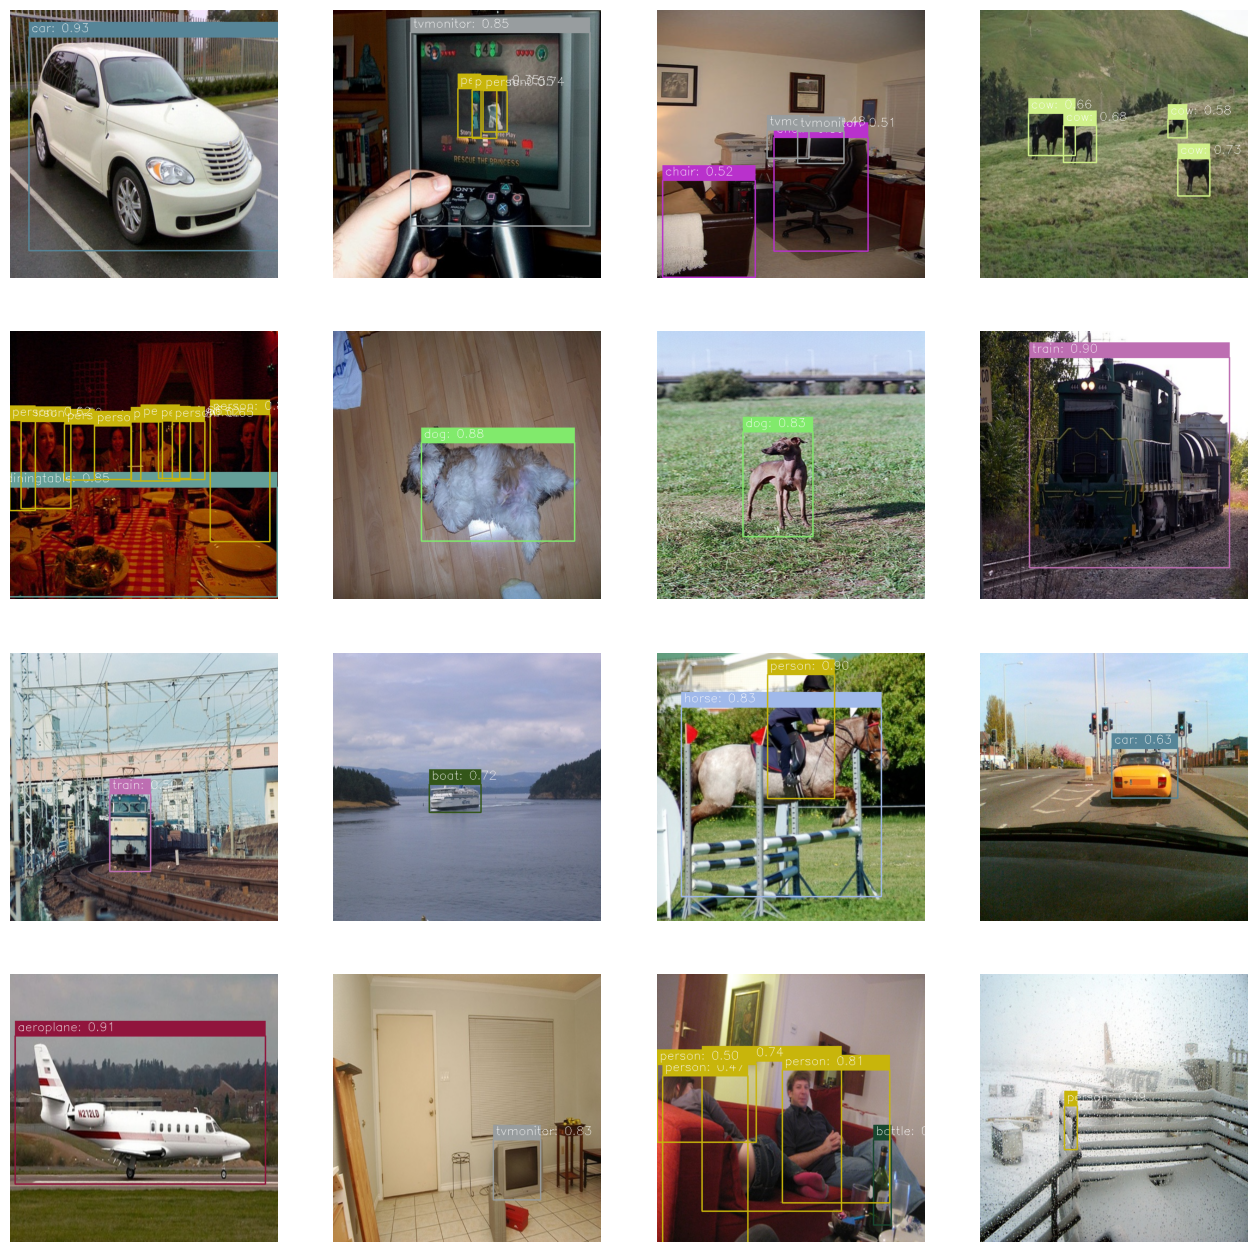

In [70]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [72]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.42
person: 0.92
person: 0.95
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 3
person: 0.68
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.84
aeroplane: 0.78
aeroplane: 0.31
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 3


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    verbose=False,
    save_dir=artifact_path.as_posix(),
)

# evaluate

In [25]:
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [26]:
VAL_IMAGE_SIZE = 544

In [41]:
decoder = Decoder(anchors.to("cpu"), CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [42]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [43]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [44]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [45]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    # shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [46]:
evaluator = Evaluator(CONTEXT)

In [40]:
# conf 0.3
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [02:00<00:00,  1.54s/it]


       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.693637  0.700719  0.693563  0.679142  0.588307  0.598702  0.679402   

            cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.68934  0.672951  0.672697  ...  0.686362  0.692691  0.694414   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.691574    0.685685  0.685571  0.685544  0.686686  0.686415  0.677131  

[1 rows x 21 columns]


In [47]:
# conf 0.1
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [01:54<00:00,  1.47s/it]


       aeroplane   bicycle     bird     boat    bottle       bus       car  \
AP@0.5  0.690376  0.751129  0.73928  0.67154  0.626641  0.643615  0.671899   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.683164  0.666114  0.666183  ...  0.734232  0.743961  0.749122   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.740128    0.682387  0.682185  0.682504  0.730832   0.73114  0.700291  

[1 rows x 21 columns]


In [48]:
result_table.T

,AP@0.5
aeroplane,0.690376
bicycle,0.751129
bird,0.73928
boat,0.67154
bottle,0.626641
bus,0.643615
car,0.671899
cat,0.683164
chair,0.666114
cow,0.666183
